# Final Alignment
Ocassionaly, astronomy.net fails to solve! This can happen for  a number of reasons and is not consistent :( 

When this happens, we need to manually align any images that failed to get sky coordinates. I prefer to make the mosaic (using mosaic.py) with the images that astronet could solve for. Then, we need to find a bright source that is in both the mosaic and the image that is missing coordinates. We use this source to align the un-solved image and apply WCS to it :) The coordinates should be in physical or image units (in all the examples that I have done, they are identical).

In [2]:
# Imports!
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
import skimage.registration as skf

In [4]:
# Load the image and the WCS
mosaic_hdu = fits.open('../M101/i/mosaic.fits')[0]  # load mosaic with WCS
image_none = fits.open('../M101/i/stacked_5.fits')[0]  # Load image missing WCS
wcs = WCS(mosaic_hdu.header)

# Source coordinates in mosaic and in non-solved image
src_mos = [1755, 1295]  # mosaic coordinates  -- this is just an example
src_non = [906, 511]  # non-solved coordinates  -- this is just an example
# We now need to calculate the shift from the center of the non-solved image (it is 1025x1024)
shift_ = [0,0]
if src_non[0] > 512:
    shift_[0] = src_non[0]-512
else:
    shift_[0] = 512-src_non[0]
if src_non[1] > 512:
    shift_[1] = src_non[1]-512
else:
    shift_[1] = 512-src_non[1]
#shift_ = [val-512 for val in src_non]
print(shift_)
# Now calculate the final cutout position in the mosaic
final_ = [val1-val2 for val1,val2 in zip(src_mos, shift_)]
print(final_)
# Make the cutout, including the WCS
cutout = Cutout2D(mosaic_hdu.data, position=final_, size=(1025,1024), wcs=wcs)
# Update the FITS header with the cutout WCS
image_none.header.update(cutout.wcs.to_header())
# Write the cutout to a new FITS file
cutout_filename = '../M101/i/stacked_correct_5.fits'
image_none.writeto(cutout_filename, overwrite=True)

[394, 1]
[1361, 1294]


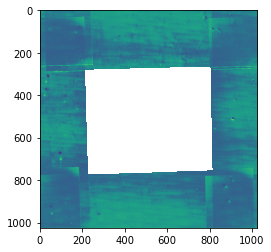

In [5]:
# Take a quick look at the results
plt.imshow(np.arcsinh(cutout.data-image_none.data))